The purpose of this notebook is to simulate a simple L or M band imaging observation with METIS. Some extra cells demonstrate functions of SimMETIS. They are marked with "INFO" and can be deleted without affecting the outcome of the simulation.

In [1]:
import numpy as np
from astropy.modeling.blackbody import blackbody_lambda
from astropy import units as u
from astropy import constants as const
from astropy.table import Table
from photutils import CircularAperture, aperture_photometry
import simmetis as sim
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

### Creating images of a point source

In [2]:
# Load the configuration file for the LM imaging mode of METIS.
#    Have a look at the config file (in the same directory as this notebook);
#    it is documented and should be self-explanatory
cmd = sim.UserCommands("metis_image_LM.config", sim_data_dir="../data")

# filter transmission curves are stored in ../data (the SIM_DATA_DIR as set in the config file given above)
metis_filter_id = "Lp"
cmd["INST_FILTER_TC"] = "TC_filter_" + metis_filter_id + ".dat"

In [3]:
# INFO -- show list of commands
cmd.cmds

OrderedDict([('OBS_DATE', 0.0),
             ('OBS_TIME', 0.0),
             ('OBS_RA', 90.0),
             ('OBS_DEC', -30.0),
             ('OBS_ALT', 0.0),
             ('OBS_AZ', 0.0),
             ('OBS_ZENITH_DIST', None),
             ('OBS_PARALLACTIC_ANGLE', 0.0),
             ('OBS_SEEING', 0.6),
             ('OBS_FIELD_ROTATION', 0.0),
             ('OBS_DIT', 1.0),
             ('OBS_NDIT', 1.0),
             ('OBS_NONDESTRUCT_TRO', 2.6),
             ('OBS_REMOVE_CONST_BG', 'no'),
             ('OBS_READ_MODE', 'single'),
             ('OBS_SAVE_ALL_FRAMES', 'no'),
             ('OBS_INPUT_SOURCE_PATH', None),
             ('OBS_FITS_EXT', 0.0),
             ('OBS_OUTPUT_DIR', '"./output.fits"'),
             ('SIM_DATA_DIR', '../data'),
             ('SIM_DETECTOR_PIX_SCALE', 0.00525),
             ('SIM_OVERSAMPLING', 1.0),
             ('SIM_PIXEL_THRESHOLD', 1.0),
             ('SIM_LAM_TC_BIN_WIDTH', 0.001),
             ('SIM_SPEC_MIN_STEP', 0.0001),
             ('

In [4]:
# build the optical train (re-samples transmission curves etc. to the required resolution and takes a moment)
#   With the default PSF this currently produces a UserWarning that can be ignored.
opt = sim.OpticalTrain(cmd)

In [5]:
# initialise a detector object: This holds the detector layout and QE curve 
#    and will later be used to add Poisson noise to the incoming photon-field.
fpa = sim.Detector(cmd, small_fov=False)

In [6]:
# generate a source with a flat spectrum and 0 mag  in the observing filter
lam, spec = sim.source.flat_spectrum(0, "TC_filter_" + metis_filter_id + ".dat")

# Source object with point source at the centre of the field
src = sim.Source(lam=lam, spectra=np.array([spec]), 
                 ref=[0], x=[0], y=[0])

# Source object for the same source offset by 1 arcsec in the y direction
dither_offset = 1    ## offsets in arcseconds
src_dither = sim.Source(lam=lam, spectra=np.array([spec]), 
                        ref=[0], x=[0], y=[dither_offset])

In [7]:
# Apply the transmission curves etc. to the source object, read out the detector / construct a FITS HDU object
#    We repeat this for the nominal position and the dither position to simulate a dithered observation.
src.apply_optical_train(opt, fpa)
hdu = fpa.read_out()

src_dither.apply_optical_train(opt,fpa)
hdu_dither = fpa.read_out()

Generating image for chip 1
Reading out chip 1 using superfast
DIT = 1.0    NDIT = 1.0
Generating image for chip 1
Reading out chip 1 using superfast
DIT = 1.0    NDIT = 1.0


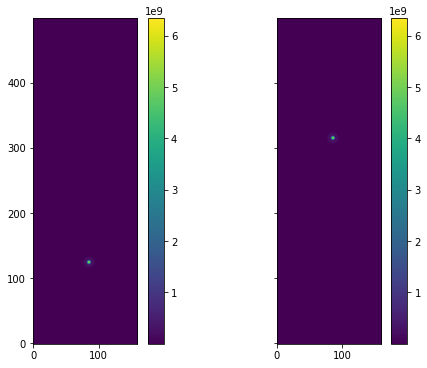

In [8]:
## Let's have a look at our object
##
## Nominal position
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,6), sharey=True)
frame1 = hdu[0].data
f1_plot = ax1.imshow(frame1[900:1400,940:1100], origin='lower')
fig.colorbar(f1_plot, ax=ax1)
##
## Dither position (frame 2)
frame2 = hdu_dither[0].data
f2_plot = ax2.imshow(frame2[900:1400,940:1100], origin='lower')
fig.colorbar(f2_plot, ax=ax2)

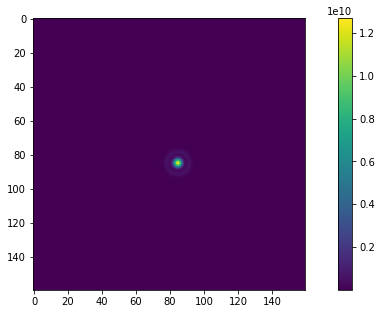

In [9]:
## Shift the dithered image back to the original position and combine the two images
##    This is the final result for this simulation.
frame_sum = frame1 + np.roll(frame2, np.int(np.round(-dither_offset/cmd["SIM_DETECTOR_PIX_SCALE"])), axis=0)
plt.figure(figsize=(12,5))
plt.imshow(frame_sum[940:1100,940:1100])
plt.colorbar()

## Adjusting exposure times

Infrared exposures are typically subdivided into NDIT subexposures, each of length DIT, so that the total integration time is DIT * NDIT. To demonstrate how to set these parameters and to show the scaling of flux levels and signal-to-noise ratios, we create a source of 10 mag and observe it using the same optical train as above. 

In [10]:
lam, spec = sim.source.flat_spectrum(17, "TC_filter_" + metis_filter_id + ".dat")

src = sim.Source(lam=lam, spectra=np.array([spec]), 
                 ref=[0], x=[0], y=[0])

src.apply_optical_train(opt, fpa)

Generating image for chip 1


In [11]:
dit = np.array([1, 1, 1, 10, 10, 10, 100, 100, 100])
ndit = np.array([3, 10, 30, 3, 10, 30, 3, 10, 30])
hdus = list()
for i in range(9):
    hdus.append(fpa.read_out(OBS_DIT=dit[i], OBS_NDIT=ndit[i]))

Reading out chip 1 using superfast
DIT = 1    NDIT = 3
Reading out chip 1 using superfast
DIT = 1    NDIT = 10
Reading out chip 1 using superfast
DIT = 1    NDIT = 30
Reading out chip 1 using superfast
DIT = 10    NDIT = 3
Reading out chip 1 using superfast
DIT = 10    NDIT = 10
Reading out chip 1 using superfast
DIT = 10    NDIT = 30
Reading out chip 1 using superfast
DIT = 100    NDIT = 3
Reading out chip 1 using superfast
DIT = 100    NDIT = 10
Reading out chip 1 using superfast
DIT = 100    NDIT = 30


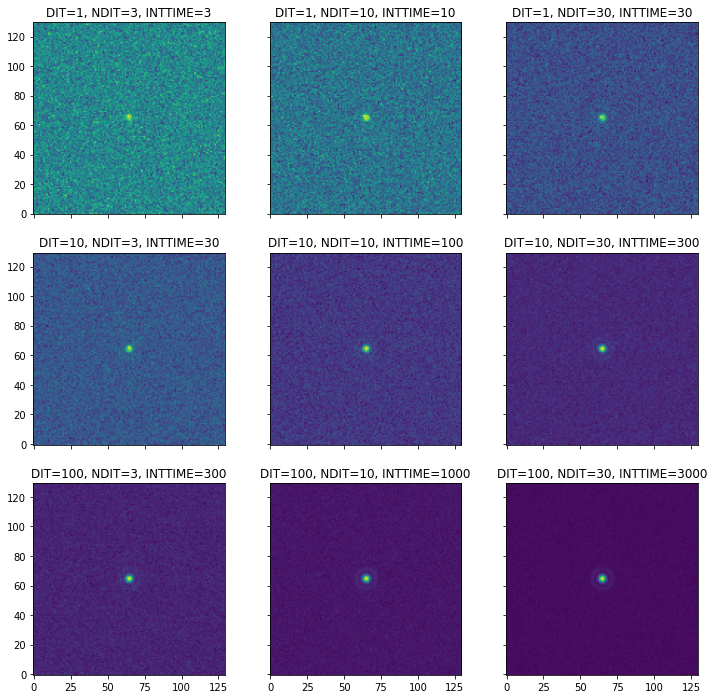

In [12]:
fig, axes = plt.subplots(3, 3, figsize=(12, 12), sharex=True, sharey=True)
for i in range(9):
    theax = axes.flat[i]
    frame = hdus[i][0].data[960:1090, 960:1090]
    theax.imshow(frame, origin='lower')
    theax.set_title("DIT={}, NDIT={}, INTTIME={}".format(dit[i], ndit[i], dit[i]*ndit[i]))

The resulting image is the average over NDIT subexposures. The scaling can be seen by looking at the background level and noise (standard deviation). 

In [13]:
aperture = CircularAperture([(1028., 1028.)], r=10.)

bglevel = np.zeros(9)
bgnoise = np.zeros(9)
starsum = np.zeros(9)
starnoise = np.zeros(9)

for i, thehdu in enumerate(hdus):
    # background stats
    bglevel[i] = np.mean(thehdu[0].data[0:800, 0:800])
    bgnoise[i] = np.std(thehdu[0].data[0:800, 0:800])
    # total signal of star
    phot_table = aperture_photometry(thehdu[0].data - bglevel[i], aperture, 
                                     error=np.ones_like(thehdu[0].data) * bgnoise[i])
    starsum[i] = phot_table['aperture_sum'][0] 
    starnoise[i] = phot_table['aperture_sum_err'][0]

In [14]:
table = Table([dit, ndit, dit * ndit, bglevel, bgnoise, starsum, starsum/starnoise], 
              names=["DIT", "NDIT", "INTTIME", "bg level", "bg noise", "Star counts", "S/N"])
table["bg level"].format = ".0f"
table["bg noise"].format = ".1f"
table["Star counts"].format = ".1f"
table["S/N"].format = ".2f"

In [15]:
table.pprint()

DIT NDIT INTTIME bg level bg noise Star counts  S/N  
--- ---- ------- -------- -------- ----------- ------
  1    3       3   263365    296.1     24084.8   4.59
  1   10      10   263366    162.4     18240.4   6.34
  1   30      30   263366     93.7     21962.0  13.22
 10    3      30  2633657    938.5    230202.5  13.84
 10   10     100  2633656    513.3    201465.7  22.15
 10   30     300  2633657    296.8    215312.2  40.92
100    3     300 26336578   2962.1   2131425.5  40.60
100   10    1000 26336568   1620.1   2162430.1  75.31
100   30    3000 26336573    936.5   2192444.0 132.09


Text(0, 0.5, 'Signal-to-noise ratio')

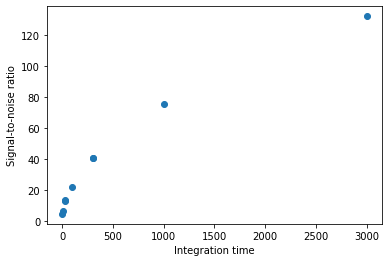

In [16]:
plt.plot(table["INTTIME"], table["S/N"], 'o')
plt.xlabel("Integration time")
plt.ylabel("Signal-to-noise ratio")

The signal-to-noise ratio increases as the square root of the total integration time, as expected.